In [35]:
import os

import numpy as np
import argparse
import pandas as pd

from fragt2vec.utility import SELECTED_MD, get_format_time, find_nearest_neighbor, draw_multiple_mol, show_each_md, reduce_by_tsne

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

import rdkit
from rdkit.Chem.Draw import IPythonConsole
# IPythonConsole.ipython_useSVG = True
from IPython.display import SVG
from sklearn.decomposition import PCA

import rdkit.Chem as Chem
from rdkit.Chem import Draw

rdkit.__version__

'2019.03.3'

In [42]:
root_dir = '../../big_data/05_model_Tandem2vec/'
need_plot_md = ['nN', 'nS', 'nBondsD', 'nARing']

In [43]:
frag2info_all = pd.read_csv(os.path.join(root_dir, 'frag_smiles2md.csv'), index_col=0)
frag2info = frag2info_all.loc[:, need_plot_md]
frag2info.head(2)

,nN,nS,nBondsD,nARing
fragment,,,,
CC,0,0,0,0
C,0,0,0,0


### model trained by FastText

In [46]:
# minn = 1
# maxn = 2

# frag_id2vec_file = 'frag_id2vec_minn_{}_maxn_{}.csv'.format(minn, maxn)
SELECTED_MD = ['nN', 'nS', 'nO', 'nX', 'nBondsD', 'nBondsT', 'naRing', 'nARing']
current_md = SELECTED_MD[-2]

root_dir = '../../big_data/06_train_frag_by_mlp'
# modle = keras.models.load_model(, 'model_reg.h5'))

frag2vec_fp = os.path.join(root_dir, current_md, 'frag2vec_new_30d.csv')

In [47]:
frag2vec = pd.read_csv(frag2vec_fp, index_col='fragment')
x_reduced = reduce_by_tsne(frag2vec)
x_reduced = pd.DataFrame(data=x_reduced, index=frag2vec.index)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3056 samples in 0.016s...
[t-SNE] Computed neighbors for 3056 samples in 0.114s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3056
[t-SNE] Computed conditional probabilities for sample 2000 / 3056
[t-SNE] Computed conditional probabilities for sample 3000 / 3056
[t-SNE] Computed conditional probabilities for sample 3056 / 3056
[t-SNE] Mean sigma: 0.227623
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.618408
[t-SNE] KL divergence after 2000 iterations: 0.870328
(3056, 2)
t-SNE took 16.3s.


#### fig. 3-2, 3-3

  >Start to plot t-SNE vis of fragment vector...


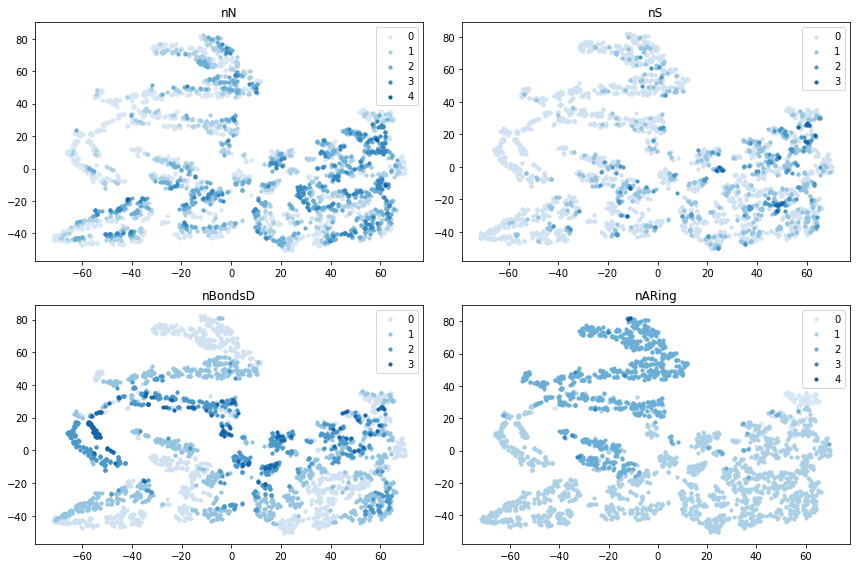

In [48]:
print('  >Start to plot t-SNE vis of fragment vector...')
save_fig_path = os.path.join('./chapter4_figure/', 't-SNE_vis_new_30d.png')
fig = show_each_md(x_reduced=x_reduced, frag_info=frag2info,
             file_path=save_fig_path)
# fig.savefig(save_fig_path, dpi=200)

In [49]:
frag2info_all.loc[:, 'MW']

fragment
CC                       30.046950
C                        16.031300
CN                       31.042199
CO                       32.026215
C1=CC=CC=C1              78.046950
                           ...    
C1OPCSP1                139.961459
C1CCOPOPOC1             168.010517
C1=CCC2CC(CCCC1)CO2     166.135765
C1=CC2=CC=C(C1)C2       104.062600
C1=CC2=CC(=C1)CSNSC2    183.017641
Name: MW, Length: 3055, dtype: float64

In [50]:
x_reduced_new = x_reduced.loc[x_reduced.index!='UNK', :].copy()
x_reduced_new.shape

(3055, 2)

In [51]:
np.all(x_reduced_new.index==frag2info_all.index)

True

In [52]:
frag2info_all.loc[:, 'MW'].max()

262.19328007200016

<Figure size 576x432 with 0 Axes>

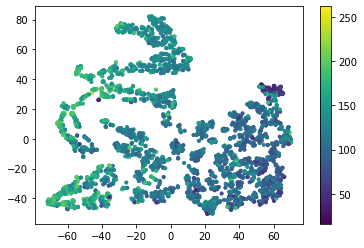

In [53]:
plt.figure(figsize=(8, 6))
# cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(x_reduced_new.loc[:, 0], x_reduced_new.loc[:, 1], 
                    c=frag2info_all.loc[:, 'MW'], s=10)
f.colorbar(points)
# plt.scatter(x_reduced.loc[:, 0], x_reduced.loc[:, 1], cmap=frag2info_all.loc[:, 'MW'])
# plt.colorbar()

#### fragment similarity

In [54]:
q_frags = ["C1=COCO1" ,"C1=CCNN=C1" ,"C1=CCC1" ,"OBr", "S=S" ,"C1#CNCC1"]
[i in frag2vec.index for i in q_frags]

[True, True, True, True, True, True]

In [55]:
q_frag2vec = frag2vec.loc[q_frags, :].copy()

In [56]:
topn = 4
nn = find_nearest_neighbor(training_mol_vec_fp=frag2vec_fp, query_mol_vec_df=q_frag2vec, top_n=topn)

current line: 0


In [57]:
def save_fig(fig, file_path):
    with open(file_path, 'w') as f_handle:
        try:
            f_handle.write(fig)
        except TypeError:
            f_handle.write(fig.data)

In [58]:
smiles_list = []
dis = []
legends = []
for inx in range(len(q_frags)):
    smiles_list += [i.split(": ")[0] for i in nn[inx][q_frags[inx]].split('; ')]
    dis += [str('{:.8f}').format(float(i.split(": ")[1])) for i in nn[inx][q_frags[inx]].split('; ')]
    # print(dis)
    # print(inx, smiles_list)
legends += ['{}({})'.format(smiles_list[i],dis[i]) for i in range(len(smiles_list))]
fig = draw_multiple_mol(smiles_list=smiles_list, mols_per_row=topn, legends=legends)
# save_fig(fig, file_path='./chapter4_figure/top{}_nearest_neighbor.svg'.format(topn))

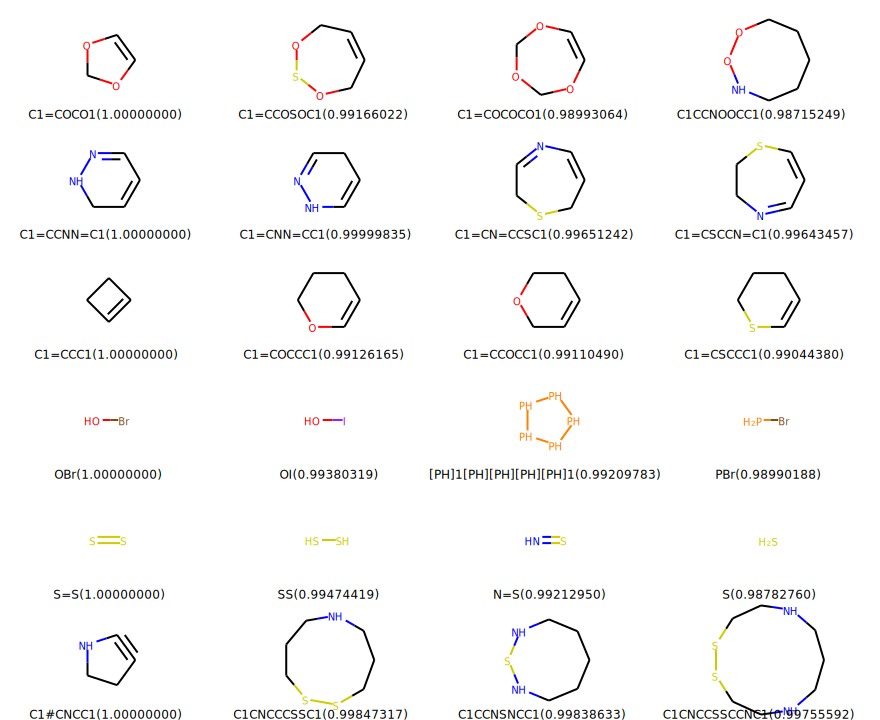

In [59]:
fig

### Analogical similarity of fragment vectors

In [20]:
# minn = 1
# maxn = 2

# frag_id2vec_file = 'frag_id2vec_minn_{}_maxn_{}.csv'.format(minn, maxn)
# frag2vec_fp = os.path.join(root_dir, frag_id2vec_file)
# print(frag2vec_fp)

# frag2vec = pd.read_csv(frag2vec_fp, index_col='fragment')
# frag2vec.head(2)

../../big_data/05_model_Tandem2vec/frag_id2vec_minn_1_maxn_2.csv


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
fragment,,,,,,,,,,,,,,,,,,,,,
CC,0.480952,1.488302,1.169265,-0.693389,0.845229,0.412012,0.701256,-0.133183,-0.165926,0.094339,...,-0.254592,0.315663,0.580485,0.000645,0.073145,-0.317370,0.069709,-0.774675,-0.081370,-0.185646
C,0.401933,1.147575,0.894457,-0.527708,0.685741,0.312301,0.526161,-0.104037,-0.141404,0.061230,...,-0.228260,0.337185,0.565867,-0.044333,0.091869,-0.290008,0.081442,-0.748831,-0.105687,-0.158385


In [15]:
pca = PCA(n_components=2)

In [16]:
x_reduced_pca = pd.DataFrame(data=pca.fit_transform(frag2vec), index=frag2vec.index)
x_reduced_pca.head(2)

,0,1
fragment,,
CC,0.965136,-1.608234
C,1.062144,-1.239460


In [17]:
frag_pairs = pd.read_csv(os.path.join(root_dir, 'bond_pairs.txt'), sep='\t')
# frag_pairs2 = pd.read_csv(os.path.join(root_dir, 'bond_pair_aromatic_ring.txt'), sep='\t')
# frag_pairs = pd.concat([frag_pairs1, frag_pairs2], axis=0)
frag_pairs = frag_pairs.loc[frag_pairs['keep']==1]
print(frag_pairs.shape)
frag_pairs.head(2)

(57, 4)


,frag1,frag2,bond_type,keep
0,C=O,CO,double_bond,1.0
1,C=C,CC,double_bond,1.0


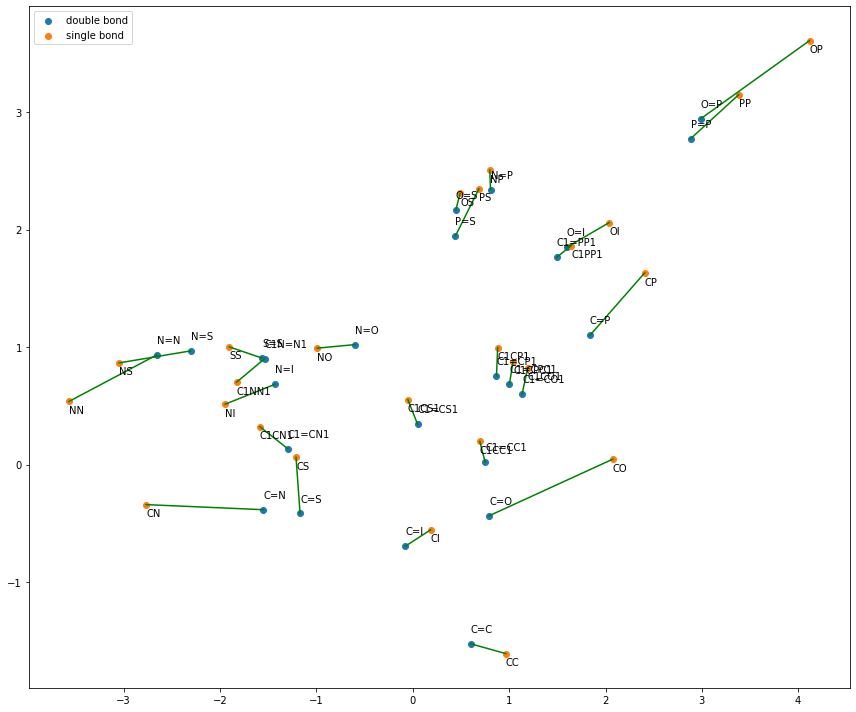

In [19]:
plt.figure(figsize=(12, 10))
for bond_type in frag_pairs['bond_type'].unique()[0:1]:
    current_frag1 = frag_pairs.loc[frag_pairs['bond_type']==bond_type, 'frag1']
    current_frag2 = frag_pairs.loc[frag_pairs['bond_type']==bond_type, 'frag2']
    frag1_vec = x_reduced_pca.loc[current_frag1, :]
    frag2_vec = x_reduced_pca.loc[current_frag2, :]
    plt.scatter(frag1_vec[0], frag1_vec[1], label='double bond')
    plt.scatter(frag2_vec[0], frag2_vec[1], label='single bond')
    for i in range(frag1_vec.shape[0]):
#         print(frag1_vec.loc[i,:].index)
        plt.text(frag1_vec.iloc[i, 0], frag1_vec.iloc[i, 1]+0.1, frag1_vec.iloc[i,:].name)
        plt.text(frag2_vec.iloc[i, 0], frag2_vec.iloc[i, 1]-0.1, frag2_vec.iloc[i,:].name)
        plt.plot([frag1_vec.iloc[i, 0], frag2_vec.iloc[i, 0]], [frag1_vec.iloc[i, 1], frag2_vec.iloc[i, 1]], c='g')
plt.legend()
plt.tight_layout()
plt.savefig('./chapter4_figure/single_double_bond_pairs.png', dpi=200)
plt.show()

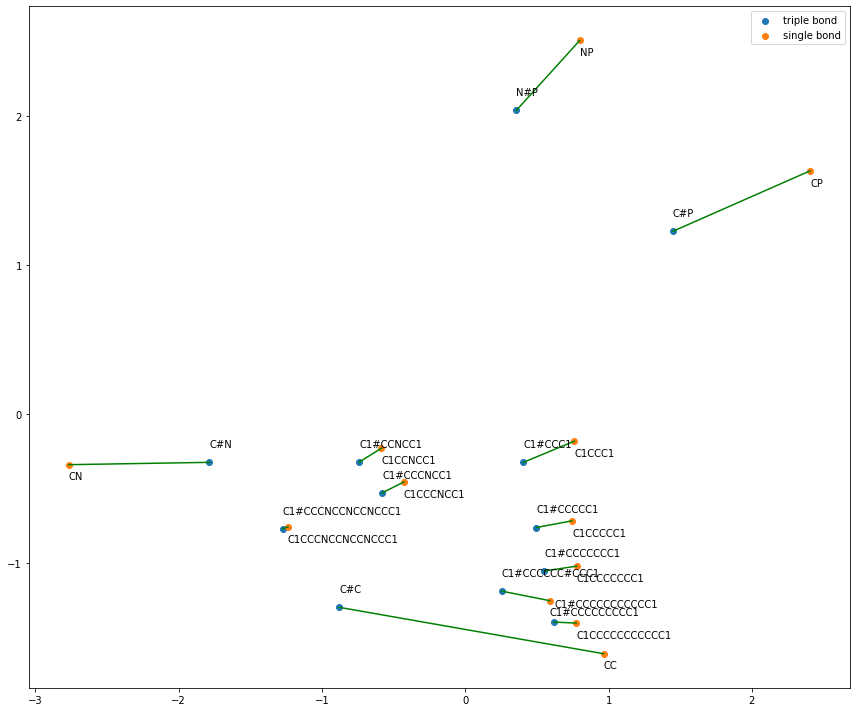

In [20]:
plt.figure(figsize=(12, 10))
for bond_type in frag_pairs['bond_type'].unique()[1:2]:
    current_frag1 = frag_pairs.loc[frag_pairs['bond_type']==bond_type, 'frag1']
    current_frag2 = frag_pairs.loc[frag_pairs['bond_type']==bond_type, 'frag2']
    frag1_vec = x_reduced_pca.loc[current_frag1, :]
    frag2_vec = x_reduced_pca.loc[current_frag2, :]
    plt.scatter(frag1_vec[0], frag1_vec[1], label='triple bond')
    plt.scatter(frag2_vec[0], frag2_vec[1], label='single bond')
    for i in range(frag1_vec.shape[0]):
#         print(frag1_vec.loc[i,:].index)
        plt.text(frag1_vec.iloc[i, 0], frag1_vec.iloc[i, 1]+0.1, frag1_vec.iloc[i,:].name)
        plt.text(frag2_vec.iloc[i, 0], frag2_vec.iloc[i, 1]-0.1, frag2_vec.iloc[i,:].name)
        plt.plot([frag1_vec.iloc[i, 0], frag2_vec.iloc[i, 0]], [frag1_vec.iloc[i, 1], frag2_vec.iloc[i, 1]], c='g')
plt.legend()
plt.tight_layout()
plt.savefig('./chapter4_figure/triple_single_bond_pairs.png', dpi=200)
plt.show()

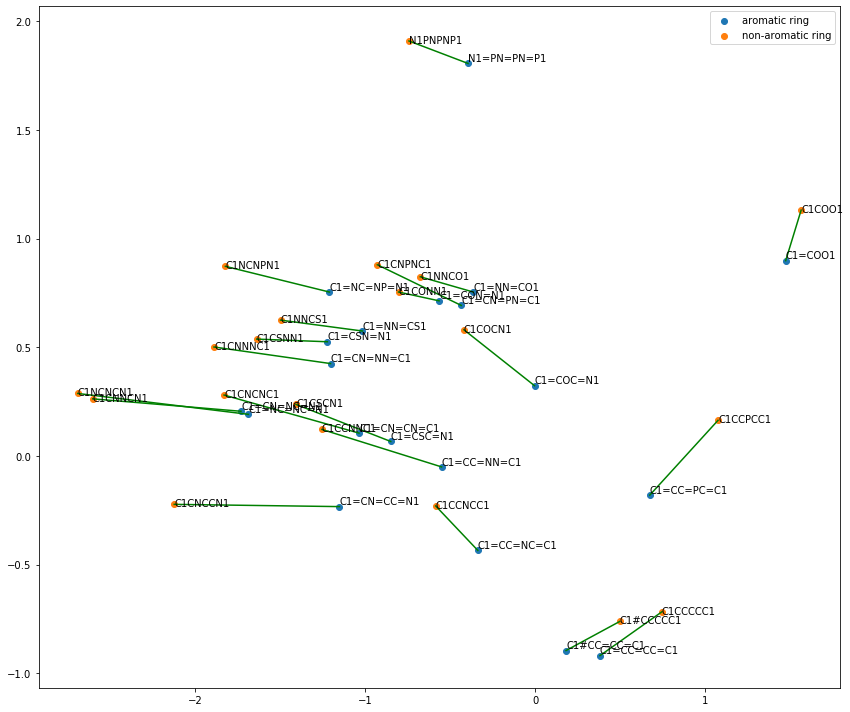

In [21]:
plt.figure(figsize=(12, 10))
for bond_type in frag_pairs['bond_type'].unique()[2:3]:
    current_frag1 = frag_pairs.loc[frag_pairs['bond_type']==bond_type, 'frag1']
    current_frag2 = frag_pairs.loc[frag_pairs['bond_type']==bond_type, 'frag2']
    frag1_vec = x_reduced_pca.loc[current_frag1, :]
    frag2_vec = x_reduced_pca.loc[current_frag2, :]
    plt.scatter(frag1_vec[0], frag1_vec[1], label='aromatic ring')
    plt.scatter(frag2_vec[0], frag2_vec[1], label='non-aromatic ring')
    for i in range(frag1_vec.shape[0]):
#         print(frag1_vec.loc[i,:].index)
        plt.text(frag1_vec.iloc[i, 0], frag1_vec.iloc[i, 1]+0.01, frag1_vec.iloc[i,:].name)
        plt.text(frag2_vec.iloc[i, 0], frag2_vec.iloc[i, 1]-0.01, frag2_vec.iloc[i,:].name)
        plt.plot([frag1_vec.iloc[i, 0], frag2_vec.iloc[i, 0]], [frag1_vec.iloc[i, 1], frag2_vec.iloc[i, 1]], c='g')
plt.legend()
plt.tight_layout()
plt.savefig('./chapter4_figure/aromatic_ring_non_aromatic_ring.png', dpi=200)
plt.show()